# Modélisation du smile de la volatilité

Dans le modèle de Heston, la dynamique du prix de l'actif sous-jacent $S_t$ est décrite par l'équation stochastique suivante :

$
dS_t = r S_t dt + \sqrt{V_t} S_t dW_t^1
$

où $r$ est le taux d'intérêt sans risque, $V_t$ est la volatilité stochastique, et $W_t^1$ est un mouvement brownien standard. La volatilité $V_t$ suit également une équation stochastique donnée par :

$
dV_t = \kappa (\theta - V_t) dt + \sigma \sqrt{V_t} dW_t^2
$

où $\kappa$ est la vitesse de réversion, $\theta$ est le niveau de volatilité à long terme, $\sigma$ est la volatilité de la volatilité, et $W_t^1$ et $W_t^2$ sont deux mouvements browniens corrélés avec un coefficient de corrélation $\rho$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import root_scalar
from typing import List
import pandas as pd

C:\Users\Eglantine Muriel\AppData\Local\Temp\ipykernel_10388\1847086123.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
S0 = 100  
V0 = 0.04  
r = 0.05  
kappa = 2  
theta = 0.04  
sigma = 0.3  
rho = -0.5  
T = 1  
N = 100#0  
M = 252 
strikes = np.linspace(80, 720, 50)

In [4]:
np.random.seed(42)
def black_scholes_asset_prices(S0: float, r: float, sigma: float, T: float, n_simulations: int, n_steps: int) -> List[float]:
    """
    Génère les prix de l'actif sous-jacent selon le modèle de Black-Scholes.

    Args:
        S0 (float): Prix initial de l'actif sous-jacent.
        r (float): Taux d'intérêt sans risque.
        sigma (float): Volatilité de l'actif sous-jacent.
        T (float): Maturité des options.
        n_simulations (int): Nombre de simulations Monte Carlo.
        n_steps (int): Nombre de pas de temps dans une simulation.

    Returns:
        List[float]: Liste des prix de l'actif sous-jacent pour chaque simulation.
    """
    dt = T / n_steps
    asset_prices = np.zeros((n_simulations, n_steps + 1))
    asset_prices[:, 0] = S0
    for i in range(1, n_steps + 1):
        Z = np.random.normal(0, 1, n_simulations)
        asset_prices[:, i] = asset_prices[:, i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return asset_prices

In [ ]:
asset_prices = black_scholes_asset_prices(S0, r, sigma, T, N, M)
time_steps = np.linspace(0, T, M + 1)  
for i in range(N):
    plt.plot(time_steps, asset_prices[i], alpha=0.5)  
plt.xlabel('Temps')
plt.ylabel('Prix de l\'actif sous-jacent')
plt.title('Prix de l\'actif généré par le modèle de Black Scholes')
plt.grid(True)
plt.show()


In [5]:
asset_prices = black_scholes_asset_prices(S0, r, sigma, T, N, M)

strikes = np.linspace(80, 720, 50)  
option_prices = np.zeros_like(strikes)  
option_payoff0 = np.zeros_like(strikes)  

for i, strike in enumerate(strikes):
    payoff0 = np.maximum(asset_prices[:,-1] - strike, 0)  
    payoffs = np.maximum(asset_prices[:,-1] - strike, 0)  
    option_prices[i] = np.mean(payoffs)
    option_payoff0[i] = payoffs[10,] # pay-off de la premiere simulation

In [24]:
print(asset_prices)

[[100.         100.93301991  99.4831149  ... 141.13192255 140.98549032
  144.60407677]
 [100.         100.53300275  99.77728972 ...  31.09085262  31.5798362
   31.71217892]
 [100.         102.21566814 103.1401244  ... 112.81601882 111.03520277
  109.3752952 ]
 ...
 [100.         100.69383562 101.12877871 ...  72.80601651  71.62694246
   70.6139307 ]
 [100.          95.09532918  95.39693441 ...  83.07181743  80.57082144
   79.64960331]
 [100.          97.43122237  99.8357233  ... 103.7328516  102.40384042
  100.73694264]]


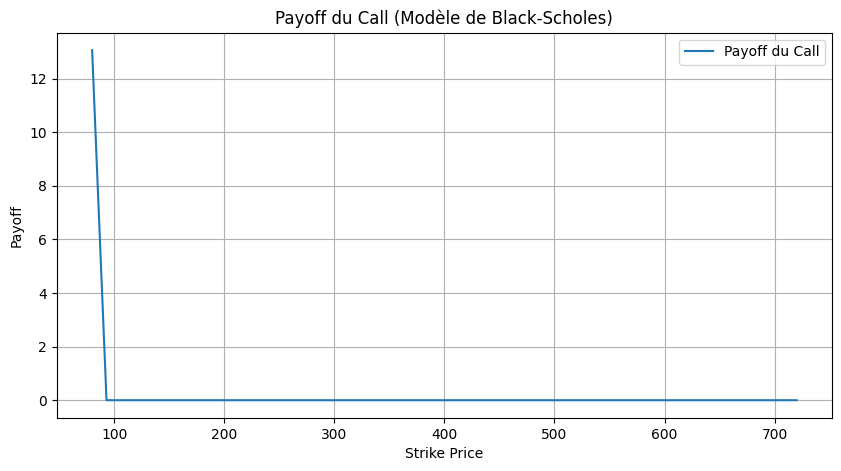

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(strikes, option_payoff0, label='Payoff du Call')
plt.xlabel('Strike Price')
plt.ylabel('Payoff')
plt.title('Payoff du Call (Modèle de Black-Scholes)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def black_scholes_call(S: float, K: float, r: float, T: float, sigma: float) -> float:
    """
    Calcule le prix d'un call européen selon le modèle de Black-Scholes.

    Args:
        S (float): Prix de l'actif sous-jacent.
        K (float): Prix d'exercice de l'option.
        r (float): Taux d'intérêt sans risque.
        T (float): Temps restant jusqu'à la maturité de l'option.
        sigma (float): Volatilité de l'actif sous-jacent.

    Returns:
        float: Prix du call européen.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

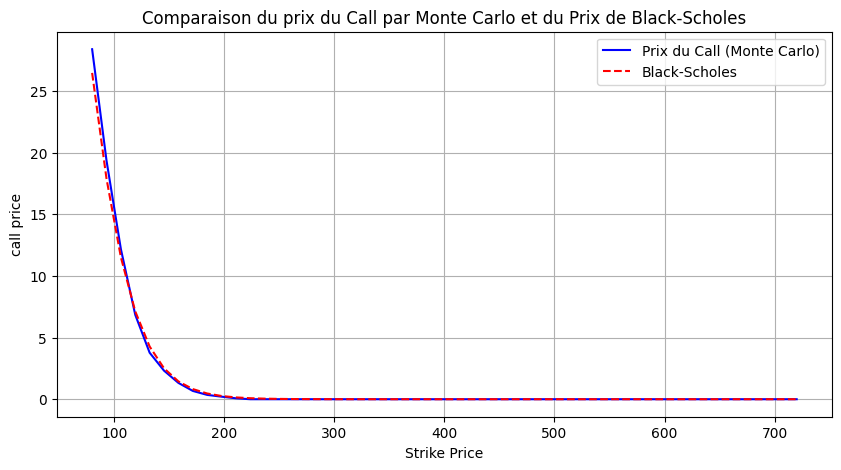

In [8]:
# Calcul du prix du call de Black-Scholes pour chaque prix d'exercice
black_scholes_prices = black_scholes_call(S0, strikes, r, T, sigma)


plt.figure(figsize=(10, 5))

plt.plot(strikes, option_prices, label='Prix du Call (Monte Carlo)', color='blue')


plt.plot(strikes, black_scholes_prices, label='Black-Scholes', linestyle='--', color='red')

plt.xlabel('Strike Price')
plt.ylabel('call price')
plt.title('Comparaison du prix du Call par Monte Carlo et du Prix de Black-Scholes')
plt.legend()
plt.grid(True)
plt.show()



La volatilité implicite ($\sigma$) est calculée en utilisant la formule de Dupire, qui est basée sur les dérivées partielles du prix de l'option par rapport au temps ($C_T$), au prix d'exercice ($C_K$), et de la dérivée seconde par rapport au prix d'exercice ($C_{KK}$), ainsi que du taux d'intérêt sans risque ($r$) et du prix d'exercice ($K$). 



$\sigma^2 = \frac{C_T + r \cdot K \cdot C_K}{\frac{1}{2} \cdot K^2 \cdot C_{KK}}$


In [9]:
def implied_volatility(T: float, K: float, r: float) -> float:
    """
    Calcule la volatilité implicite d'un call européen selon le modèle de Black-Scholes.

    Args:
        T (float): Temps restant jusqu'à la maturité de l'option.
        K (float): Prix d'exercice de l'option.
        r (float): Taux d'intérêt sans risque.

    Returns:
        float: Volatilité implicite de l'option.
    """
    epsilon = 1e-5  
    delta_K = K * epsilon  
    delta_T = T * epsilon 
    
   
    C_K = (black_scholes_call(S0, K + delta_K, r, T, sigma) - black_scholes_call(S0, K - delta_K, r, T, sigma)) / (2 * delta_K)
    C_T = (black_scholes_call(S0, K, r, T + delta_T, sigma) - black_scholes_call(S0, K, r, T - delta_T, sigma)) / (2 * delta_T)
    C_KK = (black_scholes_call(S0, K + delta_K, r, T, sigma) - 2 * black_scholes_call(S0, K, r, T, sigma) + black_scholes_call(S0, K - delta_K, r, T, sigma)) / (delta_K ** 2)
    
 
    imp_vol = np.sqrt((C_T + r * K * C_K) / (0.5 * K ** 2 * C_KK))
    #imp_vol = ((C_T + r * K * C_K) / (0.5 * K ** 2 * C_KK))

    
    return imp_vol


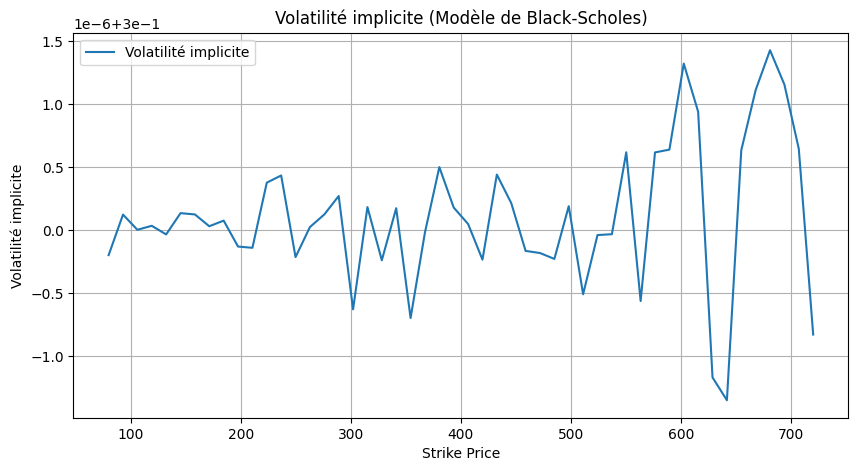

In [10]:
implied_vols = np.zeros_like(strikes)  
for i, strike in enumerate(strikes):
    implied_vols[i] = implied_volatility(T, strike, r)


plt.figure(figsize=(10, 5))
plt.plot(strikes, implied_vols, label='Volatilité implicite')
plt.xlabel('Strike Price')
plt.ylabel('Volatilité implicite')
plt.title('Volatilité implicite (Modèle de Black-Scholes)')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
def heston_asset_prices(S0: float, V0: float, r: float, kappa: float, theta: float, sigma: float, rho: float, T: float, N: int, M: int) -> np.ndarray:
    """
    Calcule les prix de l'actif sous-jacent selon le modèle de Heston par la méthode de Monte Carlo.

    Args:
        S0 (float): Prix initial de l'actif sous-jacent.
        V0 (float): Volatilité initiale.
        r (float): Taux d'intérêt sans risque.
        kappa (float): Vitesse de réversion.
        theta (float): Niveau long terme de la volatilité.
        sigma (float): Volatilité de la volatilité.
        rho (float): Corrélation entre les mouvements browniens de l'actif et de la volatilité.
        T (float): Maturité des options.
        N (int): Nombre de simulations Monte Carlo.
        M (int): Nombre de pas de temps dans une année.

    Returns:
        np.ndarray: Tableau des prix de l'actif sous-jacent pour chaque simulation.
    """
    dt = T / M  
    asset_prices = np.zeros((N, M+1))  
    for i in range(N):
        St = [S0]
        Vt = [V0]
        for t in range(1, M + 1):
            Z1 = np.random.normal(0, 1)
            Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * np.random.normal(0, 1)
            St.append(
                St[-1]
                * np.exp(
                    (r - 0.5 * Vt[-1]) * dt
                    + np.sqrt(Vt[-1] * dt) * Z1
                )
            )
            Vt.append(
                np.maximum(0, Vt[-1] + kappa * (theta - Vt[-1]) * dt + sigma * np.sqrt(Vt[-1] * dt) * Z2)
            )
        asset_prices[i] = St
    return asset_prices


In [ ]:
asset_prices = heston_asset_prices(S0, V0, r, kappa, theta, sigma, rho, T, N, M)

time_steps = np.linspace(0, T, M+1)

plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(time_steps, asset_prices[i], alpha=0.5)  

plt.xlabel('Temps (années)')
plt.ylabel('Prix de l\'actif sous-jacent')
plt.title('Prix de l\'actif généré dans le Modèle de Heston')
plt.grid(True)
plt.show()

In [8]:
def heston_call_prices(S0: float, V0: float, r: float, kappa: float, theta: float, sigma: float, rho: float, T: float, K: np.ndarray, N: int, M: int) -> np.ndarray:
    """
    Calcule les prix des options européennes de type call selon le modèle de Heston par la méthode de Monte Carlo.

    Args:
        S0 (float): Prix initial de l'actif sous-jacent.
        V0 (float): Volatilité initiale.
        r (float): Taux d'intérêt sans risque.
        kappa (float): Vitesse de réversion.
        theta (float): Niveau long terme de la volatilité.
        sigma (float): Volatilité de la volatilité.
        rho (float): Corrélation entre les mouvements browniens de l'actif et de la volatilité.
        T (float): Maturité des options.
        K (np.ndarray): Différents prix d'exercice.
        N (int): Nombre de simulations Monte Carlo.
        M (int): Nombre de pas de temps dans une année.

    Returns:
        np.ndarray: Tableau des prix des options pour chaque prix d'exercice.
    """
    asset_prices = heston_asset_prices(S0, V0, r, kappa, theta, sigma, rho, T, K, N, M)
    option_prices = np.maximum(asset_prices - K, 0)
    return np.mean(option_prices, axis=0)


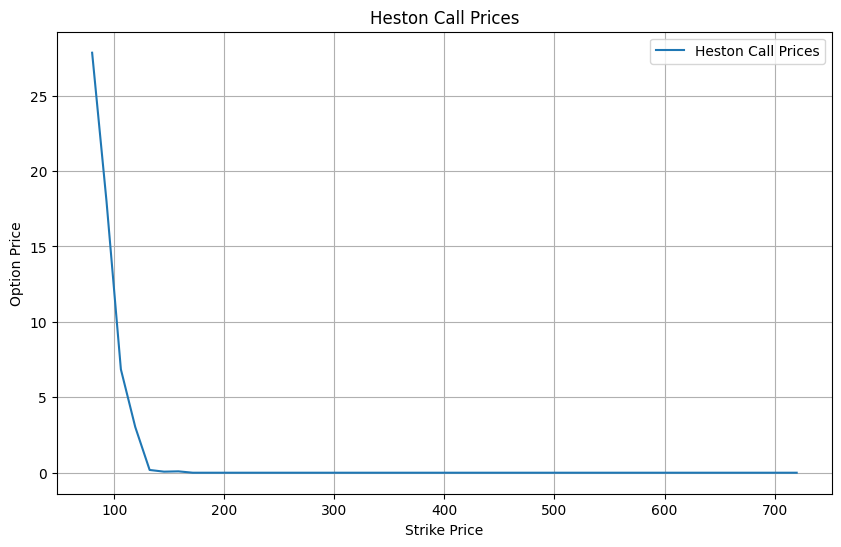

In [12]:
call_prices = heston_call_prices(S0, V0, r, kappa, theta, sigma, rho, T, strikes, N, M)


plt.figure(figsize=(10, 6))
plt.plot(strikes, call_prices, label='Heston Call Prices')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Heston Call Prices')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
def implied_volatility_heston(S0: float, V0: float, r: float, kappa: float, theta: float, sigma: float, rho: float, T: float, K: float, N: int, M: int) -> float:
    """
    Calcule la volatilité implicite d'un call européen selon le modèle de Heston.

    Args:
        S0 (float): Prix initial de l'actif sous-jacent.
        V0 (float): Volatilité initiale.
        r (float): Taux d'intérêt sans risque.
        kappa (float): Vitesse de réversion.
        theta (float): Niveau long terme de la volatilité.
        sigma (float): Volatilité de la volatilité.
        rho (float): Corrélation entre les mouvements browniens de l'actif et de la volatilité.
        T (float): Temps restant jusqu'à la maturité de l'option.
        K (float): Prix d'exercice de l'option.
        N (int): Nombre de simulations Monte Carlo.
        M (int): Nombre de pas de temps dans une année.

    Returns:
        float: Volatilité implicite de l'option selon le modèle de Heston.
    """
    epsilon = 1e-5  
    delta_K = K * epsilon  
    delta_T = T * epsilon  
    
  
    C_K = (heston_option_prices(S0, V0, r, kappa, theta, sigma, rho, T, K + delta_K, N, M) - heston_option_prices(S0, V0, r, kappa, theta, sigma, rho, T, K - delta_K, N, M)) / (2 * delta_K)
    C_T = (heston_option_prices(S0, V0, r, kappa, theta, sigma, rho, T + delta_T, K, N, M) - heston_option_prices(S0, V0, r, kappa, theta, sigma, rho, T - delta_T, K, N, M)) / (2 * delta_T)
    C_KK = (heston_option_prices(S0, V0, r, kappa, theta, sigma, rho, T, K + delta_K, N, M) - 2 * heston_option_prices(S0, V0, r, kappa, theta, sigma, rho, T, K, N, M) + heston_option_prices(S0, V0, r, kappa, theta, sigma, rho, T, K - delta_K, N, M)) / (delta_K ** 2)
    

    imp_vol = np.sqrt((C_T + r * K * C_K) / (0.5 * K ** 2 * C_KK))
    
    #return imp_vol
    return C_K,C_KK,C_T


In [14]:
implied_vols_heston = implied_volatility_heston(S0, V0, r, kappa, theta, sigma, rho, T, strikes, N, M)

print(implied_vols_heston)


# plt.plot(strikes, implied_vols_heston, label='Volatilité implicite (Heston)')
# plt.xlabel('Strike Price')
# plt.ylabel('Implied Volatility')
# plt.title('Volatilité implicite en fonction des différents Strikes (Modèle de Heston)')
# plt.legend()
# plt.grid(True)
# plt.show()

(array([1733.58301723,  354.61109972, -213.80099901, -360.73582113,
        -79.09272316,   73.10499599,   36.41138529,    0.        ,
          0.        ,    0.        ,   27.27164282,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ]), array([ 2440931.11808562, -3080640.154543  ,  1981083.97003206,
       -2064472.26578599,   411514.72969224,    95542.37837999,
        -125408.79038206,   

C:\Users\Eglantine Muriel\AppData\Local\Temp\ipykernel_20692\991591256.py:31: RuntimeWarning: divide by zero encountered in divide
  imp_vol = np.sqrt((C_T + r * K * C_K) / (0.5 * K ** 2 * C_KK))
C:\Users\Eglantine Muriel\AppData\Local\Temp\ipykernel_20692\991591256.py:31: RuntimeWarning: invalid value encountered in divide
  imp_vol = np.sqrt((C_T + r * K * C_K) / (0.5 * K ** 2 * C_KK))
C:\Users\Eglantine Muriel\AppData\Local\Temp\ipykernel_20692\991591256.py:31: RuntimeWarning: invalid value encountered in sqrt
  imp_vol = np.sqrt((C_T + r * K * C_K) / (0.5 * K ** 2 * C_KK))


In [15]:
data = pd.read_csv('snp_WSJ_08_02_2024.csv')
print(data.head())

       Date     Open     High      Low    Close
0  02/07/24  4973.05  4999.89  4969.05  4995.06
1  02/06/24  4950.16  4957.77  4934.88  4954.23
2  02/05/24  4957.19  4957.19  4918.09  4942.81
3  02/02/24  4916.06  4975.29  4907.99  4958.61
4  02/01/24  4861.11  4906.97  4853.52  4906.19


In [16]:
print(data.columns)
print(data.shape)

Index(['Date', ' Open', ' High', ' Low', ' Close'], dtype='object')
(6063, 5)


C:\Users\Eglantine Muriel\AppData\Local\Temp\ipykernel_20692\1680023866.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


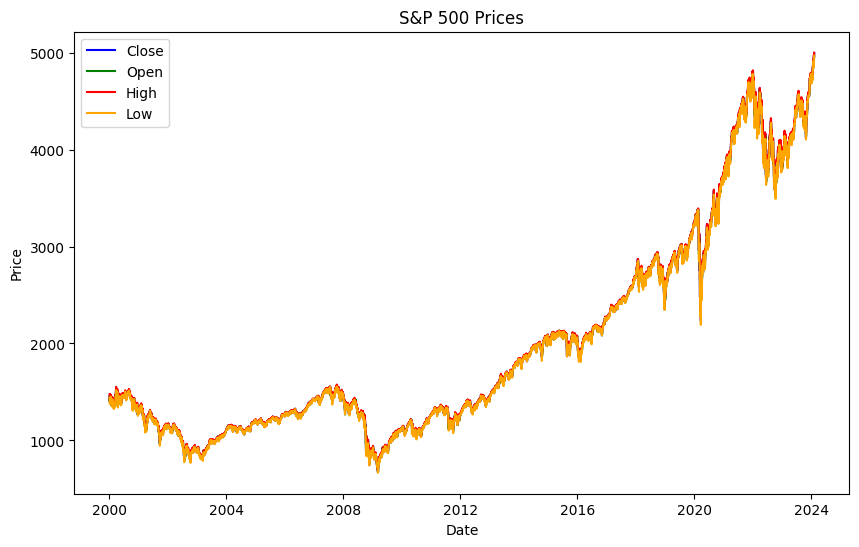

In [17]:
data['Date'] = pd.to_datetime(data['Date'])
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data[' Close'], label='Close', color='blue')
plt.plot(data['Date'], data[' Open'], label='Open', color='green')
plt.plot(data['Date'], data[' High'], label='High', color='red')
plt.plot(data['Date'], data[' Low'], label='Low', color='orange')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('S&P 500 Prices')
plt.legend()
#plt.grid(True)
plt.show()

In [18]:

data_2023 = data[data['Date'].dt.year == 2023]

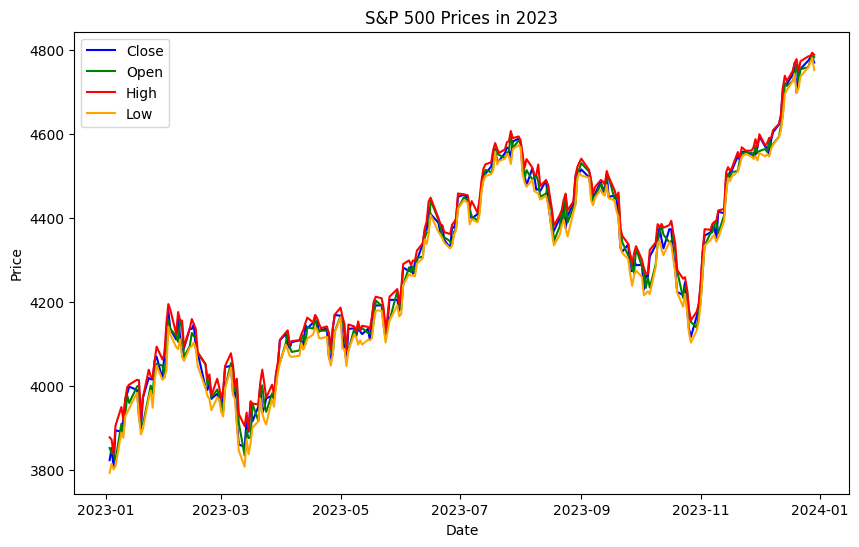

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(data_2023['Date'], data_2023[' Close'], label='Close', color='blue')
plt.plot(data_2023['Date'], data_2023[' Open'], label='Open', color='green')
plt.plot(data_2023['Date'], data_2023[' High'], label='High', color='red')
plt.plot(data_2023['Date'], data_2023[' Low'], label='Low', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('S&P 500 Prices in 2023')
plt.legend()
plt.show()

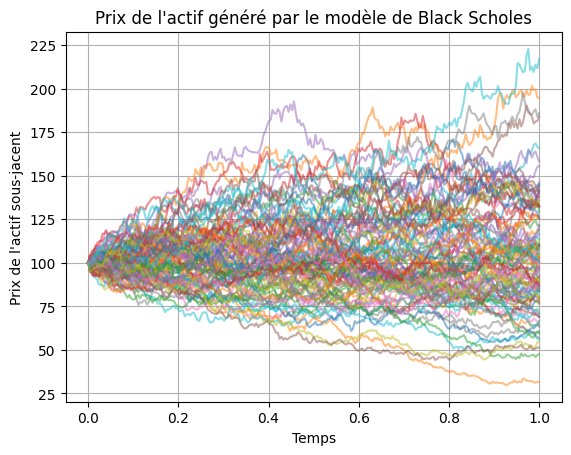

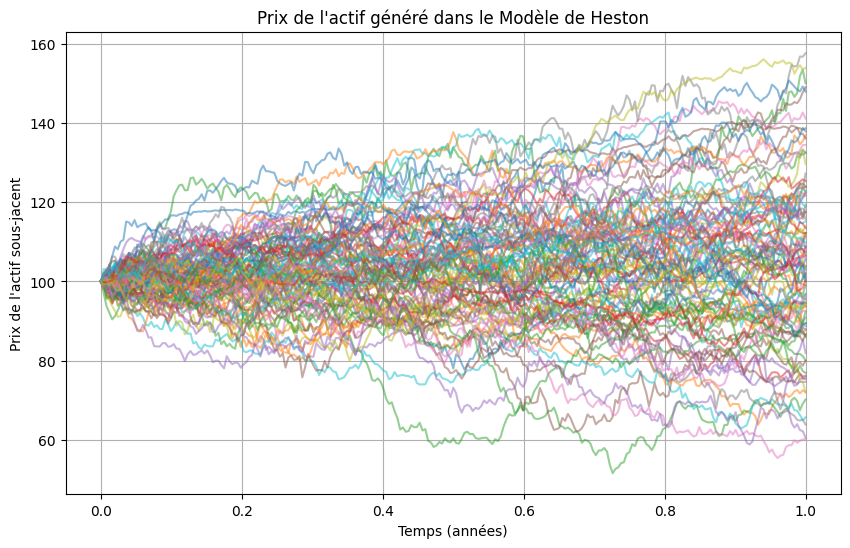